<a href="https://colab.research.google.com/github/kim-jeonghyun/advanced_detection_segmentation_model/blob/1-inference-with-sam/segment_anything_inference_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything 추론 예제 코드
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1VWB53jTGn50oTTHu3mWkBnDGxpJj8CAA/view?usp=sharing) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/kim-jeonghyun/advanced_detection_segmentation_model)


Author : [Jeonghyun Kim](kimjeonghyun.jkim@gmail.com)  
Created Date : 2023.10.24  
Reference : [Segment Anything official repository](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb)  
[Segment Anything Study post(Kor)](https://kimjeonghyun.notion.site/Segment-Anything-2023-9f5439c042784c1f953006bf84e5e7d9?pvs=4)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
import zipfile
import matplotlib.pyplot as plt
import cv2
import os
import glob

## Step 0. Setup 확인

In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/Segment-Anything-A-Foundation-Model-for-Image-Segmentation'

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/Segment-Anything-A-Foundation-Model-for-Image-Segmentation

/content/drive/MyDrive/Colab Notebooks/Segment-Anything-A-Foundation-Model-for-Image-Segmentation


In [ ]:
!python --version

In [ ]:
!cat /etc/issue

In [ ]:
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

In [ ]:
np.__version__

## Step 1. Install Segment Anything

In [ ]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8xg1u__p
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8xg1u__p
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=c8eb0708357c4d8777b2fc2fa48abb108df52d48528bb2e671f0b466e73c9784
  Stored in directory: /tmp/pip-ephem-wheel-cache-yx93w1hx/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


## Step 2. Download sample Images

샘플 이미지가 아닌 내가 가진 이미지를 사용하면 됨

In [ ]:
# def download_file(url, save_name):
#     url = url
#     if not os.path.exists(save_name):
#         file = requests.get(url)
#         open(save_name, 'wb').write(file.content)

# download_file(
#     'https://www.dropbox.com/s/0etn81u50kfs2ah/input.zip?dl=1',
#     'input.zip'
# )

In [ ]:
# # Unzip the data file
# def unzip(zip_file=None):
#     try:
#         with zipfile.ZipFile(zip_file) as z:
#             z.extractall("./")
#             print("Extracted all")
#     except:
#         print("Invalid file")

# unzip('input.zip')

Extracted all


## Step 3. Download the Models

현재 facebook에서 제공하고 있는 pretrained_weights 는 3가지
base 350mb, large 1.2gb, huge 2.5gb이므로 적절하게 선택하여 다운받을 것  
크기가 크므로 매번 다운 받을 필요는 없고 추론시 모델 위치 경로 설정만 잘해주면 됨


In [ ]:
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -O sam_vit_h.pth

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_vit_b.pth

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth -O sam_vit_l.pth

--2023-04-25 13:16:12--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.20, 52.84.162.51, 52.84.162.119, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h.pth’

sam_vit_h.pth       100%[===================>]   2.39G   231MB/s    in 12s     

2023-04-25 13:16:24 (208 MB/s) - ‘sam_vit_h.pth’ saved [2564550879/2564550879]

--2023-04-25 13:16:25--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.162.119, 52.84.162.51, 52.84.162.103, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.162.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’



## Step 4. Inference

In [ ]:
%%writefile segment.py
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import torch

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

parser = argparse.ArgumentParser()
parser.add_argument(
    '--input',
    default='input/image_4.jpg'
)
args = parser.parse_args()

if not os.path.exists('outputs'):
    os.makedirs('outputs')

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        np.dstack((img, m*0.35))
        ax.imshow(np.dstack((img, m*0.35)))

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h.pth")
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

image_path = args.input
image_name = image_path.split(os.path.sep)[-1]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
plt.figure(figsize=(12, 9))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.savefig(os.path.join('outputs', image_name), bbox_inches='tight')

Writing segment.py


In [ ]:
# !python segment.py --input input/image_1.jpg
# !python segment.py --input input/image_2.jpg
# !python segment.py --input input/image_3.jpg
# !python segment.py --input input/image_4.jpg

'input' 폴더에 있는 이미지들 한꺼번에 처리하기

In [ ]:
!python segment.py --input input/B546_FMS_8_0_1_frame200.jpg

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import argparse
import torch

from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/Segment-Anything-A-Foundation-Model-for-Image-Segmentation'

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        np.dstack((img, m*0.35))
        ax.imshow(np.dstack((img, m*0.35)))

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)


(-0.5, 853.5, 479.5, -0.5)

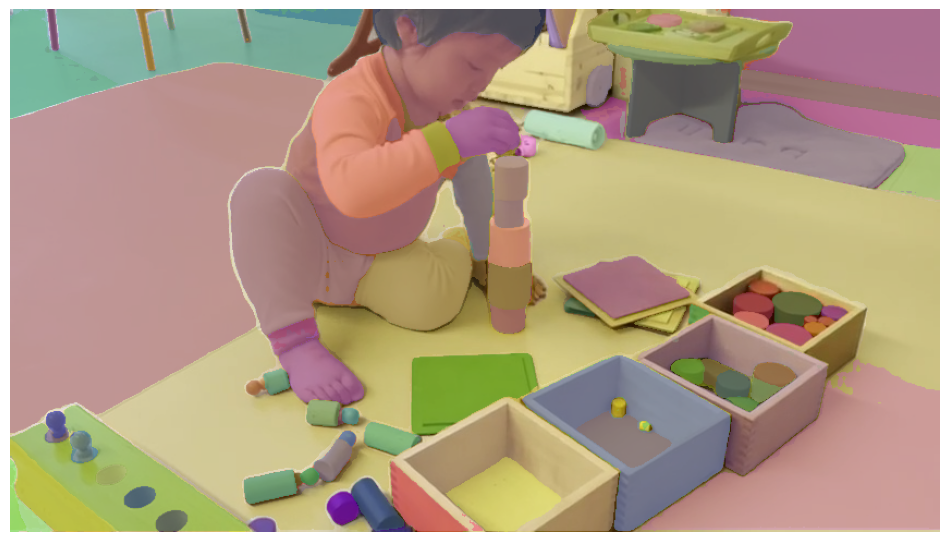

In [ ]:
image_path = "/content/drive/MyDrive/Colab Notebooks/Segment-Anything-A-Foundation-Model-for-Image-Segmentation/input/rv_683448_410_FM1_1_frame348.jpg"
image_name = image_path.split(os.path.sep)[-1]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
plt.figure(figsize=(12, 9))
plt.imshow(image)
show_anns(masks)
plt.axis('on')
# plt.savefig(os.path.join('outputs', image_name), bbox_inches='tight')

In [ ]:
masks

[{'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 18732,
  'bbox': [349, 357, 209, 121],
  'predicted_iou': 1.0109126567840576,
  'point_coords': [[386.96875, 397.5]],
  'stability_score': 0.9898625612258911,
  'crop_box': [0, 0, 854, 480]},
 {'segmentation': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'area': 13681,
  'bbox': [0, 364, 21

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
import cv2
from segment_anything import SamPredictor

predictor = SamPredictor(sam)

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
predictor.set_image(image_rgb)



In [ ]:
input_point = np.array([[450, 250]])
input_label = np.array([1])

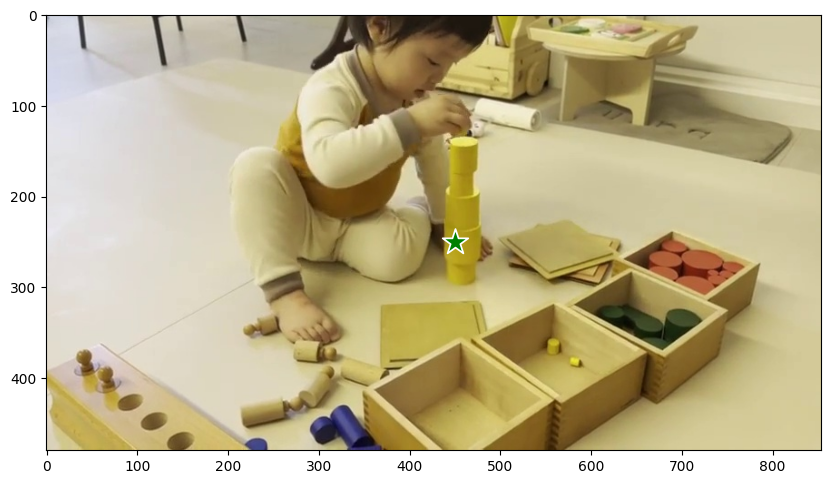

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [ ]:
?SamPredictor


In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
masks.shape  # (number_of_masks) x H x W


(3, 480, 854)

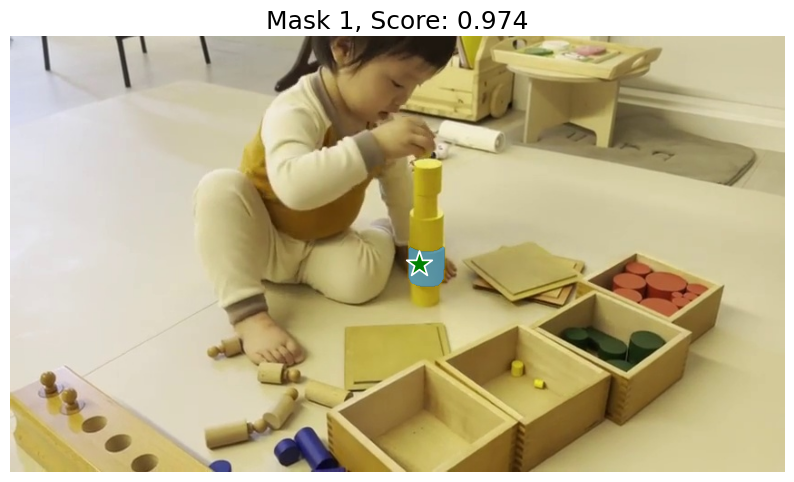

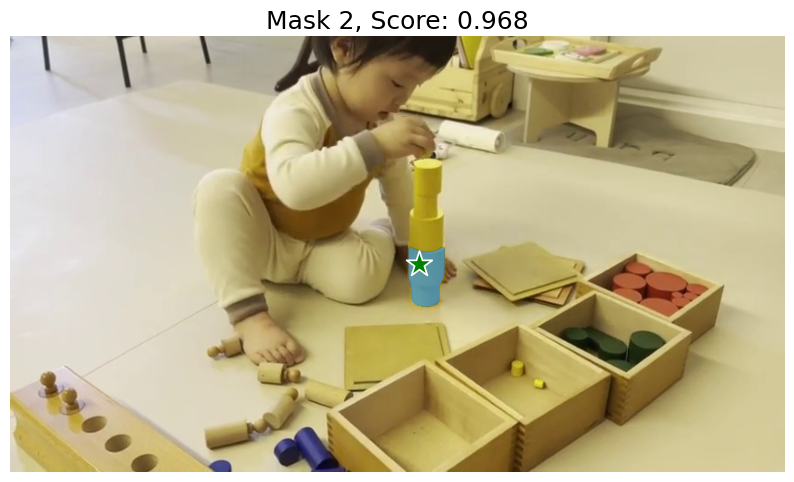

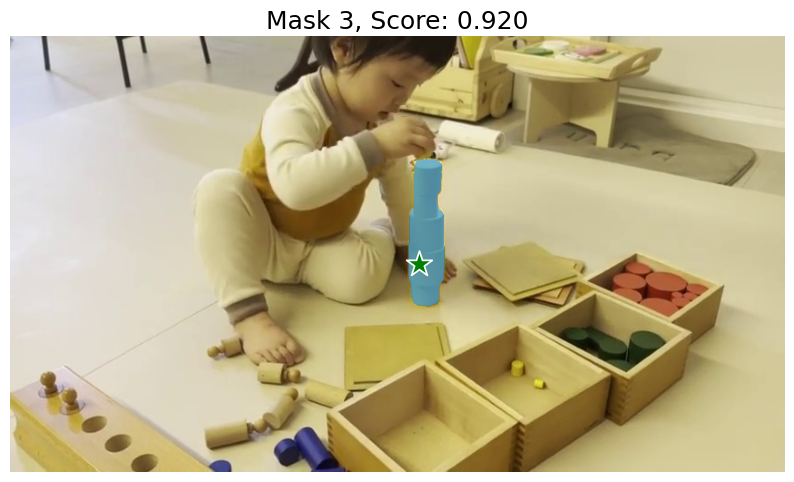

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


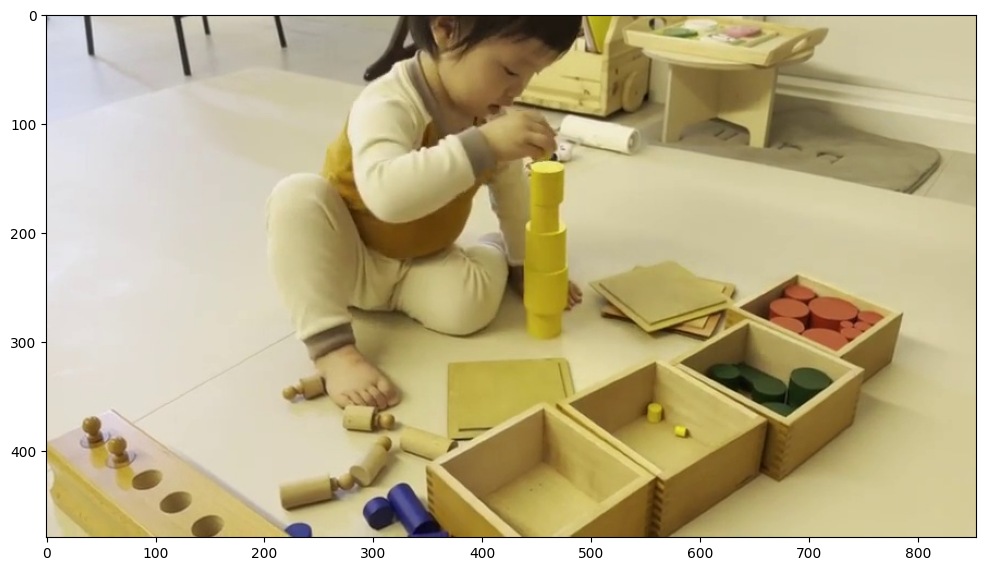

In [ ]:
plt.figure(figsize=(12, 9))
plt.imshow(image)